## Objectives of the practical work

The objective is to get hands on experience on the fundamental elements of neural networks:
 
 - perceptron architecture (linear regression)
 - loss function
 - empirical loss
 - gradient descent

For this we will implement from scratch the data-structure and algorithms to train a perceptron. Note that slides related to the perceptron and neural networks in general are available on [moodle](https://moodle.insa-toulouse.fr/course/view.php?id=1822#section-2).

## Dataset

The objective of the regression is the prediction of the hydrodynamic performance of sailing yachts from dimensions and velocity.
The **inputs** are linked to dimension and hydrodynamics characteristics:
1. Longitudinal position of the center of buoyancy
(*flottabilité*), adimensional.
2. Prismatic coefficient, adimensional.
3. Length-displacement ratio, adimensional.
4. Beam -draught ratio ((*tiran d’eau*), adimensional.
5. Length-beam ratio, adimensional.
6. Froude number, adimensional

**Target value/predicted value (Output)** = Residuary resistance per unit weight of
displacement, adimensional

In [1]:
# Import some useful libraries and functions

import numpy as np
import pandas
import matplotlib.pyplot as plt 

def print_stats(dataset):
    """Print statistics of a dataset"""
    print(pandas.DataFrame(dataset).describe())


In [2]:
# Download the data set and place in the current folder (works on linux only)
filename = 'yacht_hydrodynamics.data'

import os.path
import requests

if not os.path.exists(filename):
    print("Downloading dataset...")
    r = requests.get('https://arbimo.github.io/tp-supervised-learning/tp2/' + filename)
    open(filename , 'wb').write(r.content)
    
print('Dataset available')

Dataset available


### Explore the dataset

- how many examples are there in the dataset?
- how many features for each example?
- what is the ground truth of the 10th example

In [3]:
# loads the dataset and slip between inputs (X) and ground truth (Y)
dataset = np.genfromtxt("yacht_hydrodynamics.data", delimiter='')
X = dataset[:, :-1] # examples features
Y = dataset[:, -1]  # ground truth

# Print the first 5 examples
for i in range(0,5):
    print(f"f({X[i]}) = {Y[i]}")

f([-5.    0.6   4.78  4.24  3.15  0.35]) = 8.62
f([-5.     0.565  4.77   3.99   3.15   0.15 ]) = 0.18
f([-2.3    0.565  4.78   5.35   2.76   0.15 ]) = 0.29
f([-5.     0.6    4.78   4.24   3.15   0.325]) = 6.2
f([0.    0.53  4.78  3.75  3.15  0.175]) = 0.59


In [4]:
#Nombre d'exemples présents dans le dataset
print("taille dataset:", len(X))

taille dataset: 308


In [5]:
#Pour chaque exemple, nombre de features sélectionnées
#On les retrouve ici:
# 1. Longitudinal position of the center of buoyancy (flottabilité), adimensional.
# 2. Prismatic coefficient, adimensional.
# 3. Length-displacement ratio, adimensional.
# 4. Beam -draught ratio ((tiran d’eau), adimensional.
# 5. Length-beam ratio, adimensional.
# 6. Froude number, adimensional
print("nombre de features:", len(X[0]))

nombre de features: 6


In [6]:
# Ground truth est un terme utilisé en statistique et en apprentissage automatique qui signifie que l'on vérifie l'exactitude des résultats de l'apprentissage automatique par rapport au monde réel.
# Voici celui du 10ème exemple
print(f"f({X[9]}) = {Y[9]}")

f([-5.     0.565  4.77   3.99   3.15   0.25 ]) = 1.83


The following command adds a column to the inputs.

- what is in the value added this column?
- why are we doing this?

In [7]:
X = np.insert(X, 0, np.ones((len(X))), axis= 1)
print_stats(X)


           0           1           2           3           4           5  \
count  308.0  308.000000  308.000000  308.000000  308.000000  308.000000   
mean     1.0   -2.381818    0.564136    4.788636    3.936818    3.206818   
std      0.0    1.513219    0.023290    0.253057    0.548193    0.247998   
min      1.0   -5.000000    0.530000    4.340000    2.810000    2.730000   
25%      1.0   -2.400000    0.546000    4.770000    3.750000    3.150000   
50%      1.0   -2.300000    0.565000    4.780000    3.955000    3.150000   
75%      1.0   -2.300000    0.574000    5.100000    4.170000    3.510000   
max      1.0    0.000000    0.600000    5.140000    5.350000    3.640000   

                6  
count  308.000000  
mean     0.287500  
std      0.100942  
min      0.125000  
25%      0.200000  
50%      0.287500  
75%      0.375000  
max      0.450000  


In [8]:
#On a rajouté des 1 pour avoir une référence de base concernant performance hydrodynalique
print(X[0]) #On a rajouté une colonne avec que des 1 tout devant, c'est une référence de base à ce que l'on essaie
print(X[1]) #de prédire

[ 1.   -5.    0.6   4.78  4.24  3.15  0.35]
[ 1.    -5.     0.565  4.77   3.99   3.15   0.15 ]


## Creating the perceptron

![Perceptron for regression](https://arbimo.github.io/tp-supervised-learning/tp2/perceptron-regression.png)

We now want to define a perceptron, that is, a function of the form: 

$h_w(x) = w_0 + w_1 \times x_1 + \dots + w_n \times x_n$

- Complete the code snippet below to:
  - create the vector of weight `w`
  - implement the `h` function that evaluate an example based on the vector of weights
  - check if this works on a few examples

In [9]:
#Nombre de poids
N = 7
w = np.zeros(N) # définition du vecteur poids W avec tous les poids à 0

# Définition de la fonction d'approximation de Y grâce aux entrées X, à notre référence de base X0 et à notre 
def h(w, x): # vecteur poids
    return np.dot(w,x)

In [10]:
# print the ground truth and the evaluation of h_w on the first example
h(w,X[0])

0.0

## Loss function

Complete the definiton of the loss function below such that, for a **single** example `x` with ground truth `y`, it returns the $L_2$ loss of $h_w$ on `x`.

In [14]:
# Nous allons implémenter plusieurs loss, la L1, L2 et la loss 0/1
# pour à la fin pouvoir voir l'impact du choix de la loss sur la descente de gradient
#Définition de la loss 2 L2
def loss_2(w, x, y):
    y_predic = h(w,x)
    
    # Test en cas d'explosion du Y_predict
    if y_predic > 10e6:
        print("Loss 2 :Y predict", y_predic)
    return (y-y_predic)**2


In [15]:
loss_2(w,X[0],Y[0])

74.30439999999999

In [16]:
#Définition de la loss 1 L1
def loss_1(w, x, y):
    y_predic = h(w,x)
    
    # Test en cas d'explosion du Y_predict
    if y_predic > 10e6:
        print("Loss 1 Y predict", y_predic)
    return abs(y-y_predic)

In [17]:
loss_1(w,X[0],Y[0])

8.62

In [18]:
#Définition de la loss 1 L1
def loss_01(w, x, y):
    y_predic = h(w,x)
        # Test en cas d'explosion du Y_predict
    if y_predic > 10e6:
        print("Y predict", y_predic)
    
    if y_predic==y:
        return 0
    else:
        return 1

In [19]:
loss_01(w,X[0],Y[0])

1

## Empirical loss

Complete the function below to compute the empirical loss of $h_w$ on a **set** of examples $X$ with associated ground truths $Y$.

In [20]:
# Ne connaissant pas la probabilité de redistribution parmis les exemples,
#  nous n'utiliserons pas la loss generalisée mais plutôt la loss empirique
# Définition de la loss empirique
def emp_loss(w, X, Y, loss):
    emp_l = 0
    for i in range(0,len(X)):
        emp_l = emp_l + loss(w, X[i], Y[i])
    return emp_l/len(X)

In [21]:
# Valeur de la loss empirique en utilisant nos ensemble X et Y avec la loss 2
emp_loss(w,X,Y, loss_2)

339.2467464285712

In [22]:
# Valeur de la loss empirique en utilisant nos ensemble X et Y avec la loss 1
emp_loss(w,X,Y, loss_1)

10.495357142857156

In [23]:
# Valeur de la loss empirique en utilisant nos ensemble X et Y avec la loss 0/1
emp_loss(w,X,Y, loss_01)

1.0

## Gradient update

A gradient update is of the form: $w \gets w + dw$

- Complete the function below so that it computes the $dw$ term (the 'update') based on a set of examples `(X, Y)` the step (`alpha`)

If you are not sure about the gradient computation, check out the [perceptron slides](https://moodle.insa-toulouse.fr/pluginfile.php/120391/mod_resource/content/1/cm1.pdf) on [Moodle](https://moodle.insa-toulouse.fr/course/view.php?id=1822) (in particular, slide 26). Make sure this computation is clear to you!

In [24]:
#Mise à jour du vecteur de poids avec le pas alpha
def compute_update(w, X, Y, loss, alpha):
    
    for j in range(0, len(X)):
        for i in range(0,len(w)):
            if loss==loss_2: #update rule wnew = w - alpha * gradientLoss(w)
                w[i] = w[i] + alpha * (Y[j]-h(w,X[j]))*X[j,i]
            else:
                w[i] = w[i] + alpha * X[j,i] * (Y[j]-h(w,X[j]))/abs((Y[j]-h(w,X[j]))) # Cas de la loss L1  

    return w
                   

compute_update(w, X, Y, loss_2, alpha = 10e-7)

array([ 0.00320675, -0.00750108,  0.0018059 ,  0.01535208,  0.01259179,
        0.0102817 ,  0.00130237])

## Gradient descent

Now implement the gradient descent algorithm that will:

- repeatedly apply an update the weights 
- stops when a max number of iterations is reached (do not consider early stopping for now)
- returns the final vector of weights

In [25]:
def descent(w_init, X, Y, loss, alpha, max_iter):
    
    w = np.copy(w_init)
    w_prec = np.zeros(N)
    iterateur = []
    i = 0
    iterateur.append(i)
    
    Loss = []
    Loss.append(emp_loss(w, X, Y,loss))
    
    # On pourrait rajouter un critère de convergence lorsque le vecteur poids ne change quasi plus ou la norme
    # np.linalg.norm(w_prec-w)>= (degrès de précision) OU emp_loss(w, X, Y)>= degrés de précision
    while i < max_iter:
        w_prec = np.copy(w)
        w=compute_update(w, X, Y, loss, alpha)
        Loss.append(emp_loss(w, X, Y,loss))
        i=i+1
        iterateur.append(i)
        
    #On retourne le nombre d'itérations nécéssaires, un tableau contenant les différents passages dans la boucles
    # en vue d'un affichage, la valeur de la Loss ainsi que le vecteur poids
    return i, iterateur, Loss, w

## Exploitation

You gradient descent is now complete and you can exploit it to train your perceptron.

- Train your perceptron to get a model.
- Visualize the evolution of the loss on the training set. Has it converged?
- Try training for several choices of `alpha` and `max_iter`. What seem like a reasonable choice?
- What is the loss associated with the final model?
- Is the final model the optimal one for a perceptron?


In [33]:
W = np.zeros(N) # On initialise le vecteur poids qu'avec des 0

#Loss 2 utilisée
nb_ite_1, suivi_it_1, Loss_1, w_1 = descent(W, X, Y, loss_2, 10e-7, 10000)
nb_ite_2, suivi_it_2, Loss_2, w_2 = descent(W, X, Y, loss_2, 10e-7, 30000)
nb_ite_3, suivi_it_3, Loss_3, w_3 = descent(W, X, Y, loss_2, 10e-5, 10000)
nb_ite_4, suivi_it_4, Loss_4, w_4 = descent(W, X, Y, loss_2, 10e-5, 30000)
nb_ite_11, suivi_it_11, Loss_11, w_11 = descent(W, X, Y, loss_2, 10e-3, 10000)
nb_ite_22, suivi_it_22, Loss_22, w_22 = descent(W, X, Y, loss_2, 10e-3, 30000)
nb_ite_111, suivi_it_111, Loss_111, w_111 = descent(W, X, Y, loss_2, 10e-1, 10000)
nb_ite_222, suivi_it_222, Loss_222, w_222 = descent(W, X, Y, loss_2, 10e-1, 30000)

#Loss 1 utilisée
nb_ite_5, suivi_it_5, Loss_5, w_5 = descent(W, X, Y, loss_1, 10e-7, 10000)
nb_ite_6, suivi_it_6, Loss_6, w_6 = descent(W, X, Y, loss_1, 10e-7, 30000)
nb_ite_7, suivi_it_7, Loss_7, w_7 = descent(W, X, Y, loss_1, 10e-5, 10000)
nb_ite_8, suivi_it_8, Loss_8, w_8 = descent(W, X, Y, loss_1, 10e-5, 30000)
nb_ite_55, suivi_it_55, Loss_55, w_55 = descent(W, X, Y, loss_1, 10e-3, 10000)
nb_ite_66, suivi_it_66, Loss_66, w_66 = descent(W, X, Y, loss_1, 10e-3, 30000)
nb_ite_555, suivi_it_555, Loss_555, w_555 = descent(W, X, Y, loss_1, 10e-1, 10000)
nb_ite_666, suivi_it_666, Loss_666, w_666 = descent(W, X, Y, loss_1, 10e-1, 30000)

#Loss 0/1 utilisée
#nb_ite_9, suivi_it_9, Loss_9, w_9 = descent(W, X, Y, loss_01, 10e-7, 10000)
#nb_ite_10, suivi_it_10, Loss_10, w_10 = descent(W, X, Y, loss_01, 10e-7, 30000)
#nb_ite_11, suivi_it_11, Loss_11, w_11 = descent(W, X, Y, loss_01, 10e-5, 10000)
#nb_ite_12, suivi_it_12, Loss_12, w_12 = descent(W, X, Y, loss_01, 10e-5, 30000)

In [28]:
# Nous allons utiliser l'indicateur r2 pour évaluer la précision des prédictions de notre modèle
# Plus le R2 est proche de 1, plus notre modèle a été précis
from sklearn.metrics import r2_score

In [29]:
# Affichage de l'évolution de la loss en fonction des itérations
def print_Loss(suivi_it, Loss):
    plt.plot(suivi_it, Loss)
    plt.xlabel("Nombre itérations")
    plt.ylabel("Valeur de la loss")

In [30]:
# Code sample that can be used to visualize the difference between the ground truth and the prediction
def print_accurancy_model(w, number_sample):
    num_samples_to_plot = number_sample
    plt.plot(Y[0:num_samples_to_plot], 'ro', label='y')
    yw = [h(w,x) for x in X]
    plt.plot(yw[0:num_samples_to_plot], 'bx', label='$\hat{y}$')
    plt.legend()
    plt.xlabel("Examples")
    plt.ylabel("f(examples)")

In [31]:
# Fonction permettant le calcul du r2
def r2(w, number_sample):
    num_samples_to_plot = number_sample
    yw = [h(w,x) for x in X]
    return r2_score(Y[0:num_samples_to_plot],yw[0:num_samples_to_plot])

## Exemples avec la loss 2:

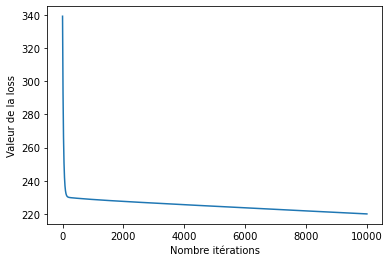

In [34]:
print_Loss(suivi_it_1, Loss_1)

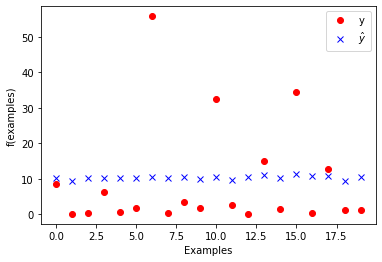

In [35]:
print_accurancy_model(w_1, 20)

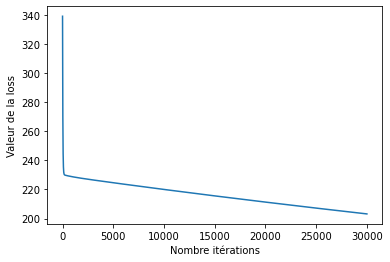

In [36]:
print_Loss(suivi_it_2, Loss_2)

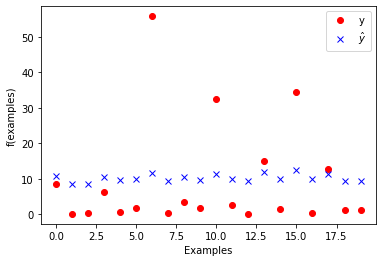

In [37]:
print_accurancy_model(w_2, 20)

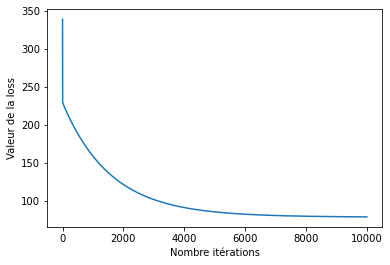

In [38]:
print_Loss(suivi_it_3, Loss_3)

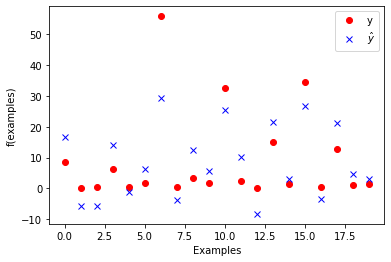

In [39]:
print_accurancy_model(w_3, 20)

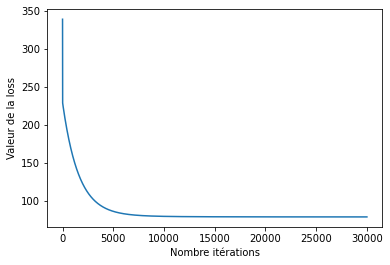

In [40]:
print_Loss(suivi_it_4, Loss_4)

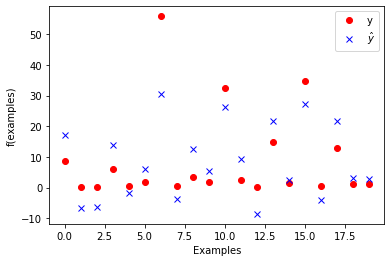

In [41]:
print_accurancy_model(w_4, 20)

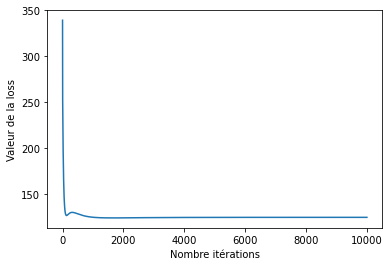

In [42]:
print_Loss(suivi_it_11, Loss_11)

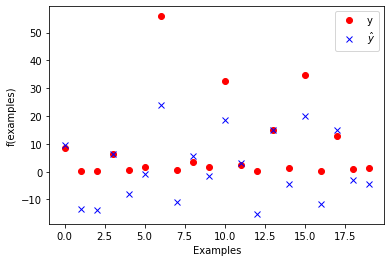

In [43]:
print_accurancy_model(w_11, 20)

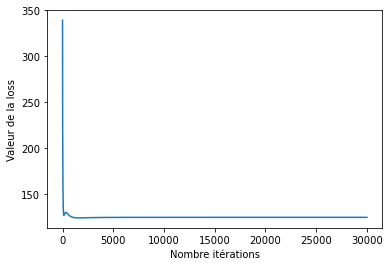

In [44]:
print_Loss(suivi_it_22, Loss_22)

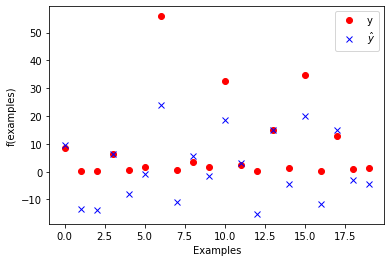

In [45]:
print_accurancy_model(w_22, 20)

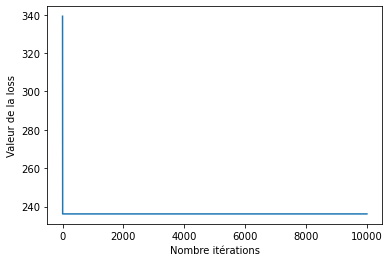

In [46]:
print_Loss(suivi_it_111, Loss_111)

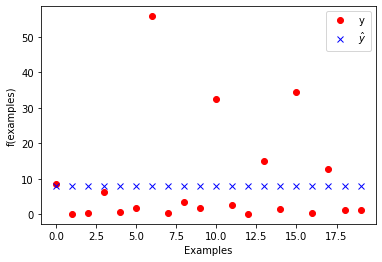

In [47]:
print_accurancy_model(w_111, 20)

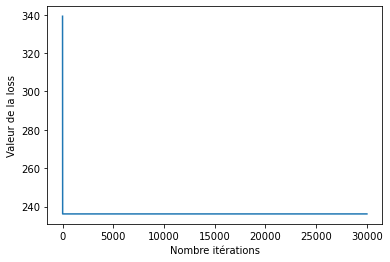

In [48]:
print_Loss(suivi_it_222, Loss_222)

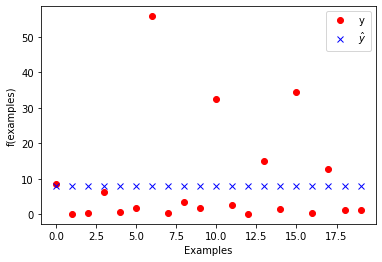

In [49]:
print_accurancy_model(w_222, 20)

In [50]:
print("w1 R2:", r2(w_1,100))
print("w2 R2:", r2(w_2,100))
print("w3 R2:", r2(w_3,100))
print("w4 R2:", r2(w_4,100))
print("w11 R2:", r2(w_11,100))
print("w22 R2:", r2(w_22,100))
print("w111 R2:", r2(w_111,100))
print("w222 R2:", r2(w_222,100))

# Nous avons qu'en utilisant w3, w4, w11 les modèles les plus précis

w1 R2: 0.008778762418283792
w2 R2: 0.08561182202566953
w3 R2: 0.6538120988949359
w4 R2: 0.6556073044248025
w11 R2: 0.45147710354944015
w22 R2: 0.4514779398431268
w111 R2: -0.001379412883961706
w222 R2: -0.0013794914185594198


## Exemples Loss 1 :

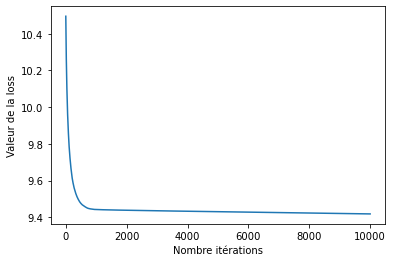

In [51]:
print_Loss(suivi_it_5, Loss_5)

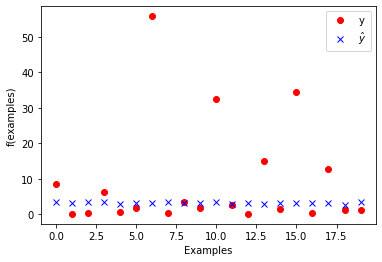

In [52]:
print_accurancy_model(w_5, 20)

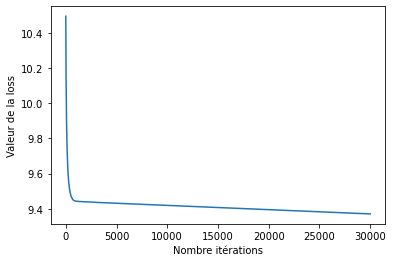

In [53]:
print_Loss(suivi_it_6, Loss_6)

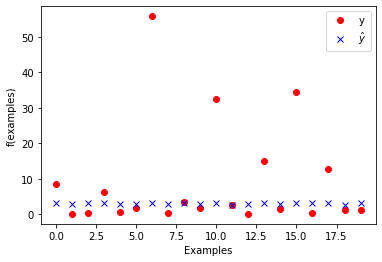

In [54]:
print_accurancy_model(w_6, 20)

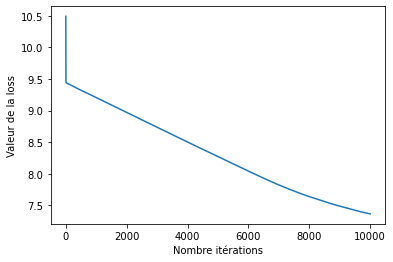

In [55]:
print_Loss(suivi_it_7, Loss_7)

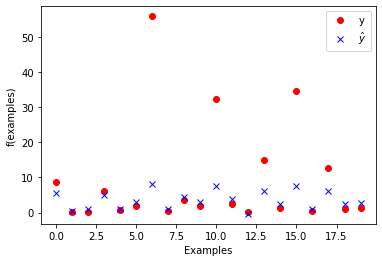

In [56]:
print_accurancy_model(w_7, 20)

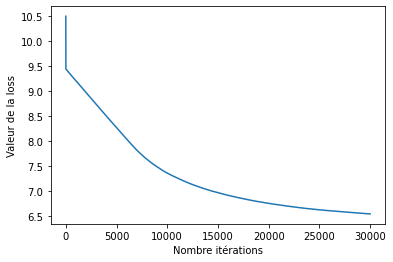

In [57]:
print_Loss(suivi_it_8, Loss_8)

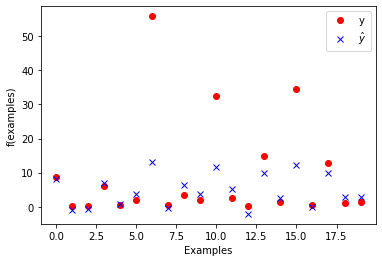

In [58]:
print_accurancy_model(w_8, 20)

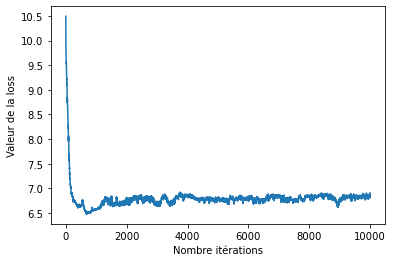

In [59]:
print_Loss(suivi_it_55, Loss_55)

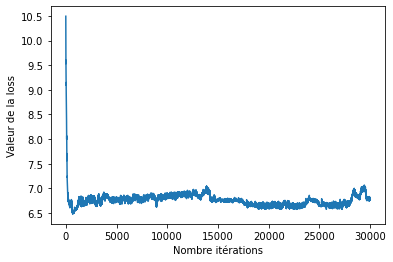

In [60]:
print_Loss(suivi_it_66, Loss_66)

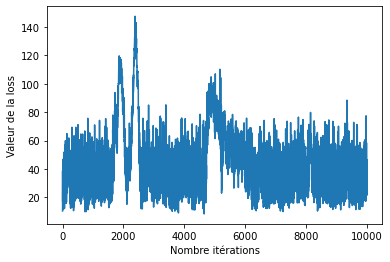

In [61]:
print_Loss(suivi_it_555, Loss_555)

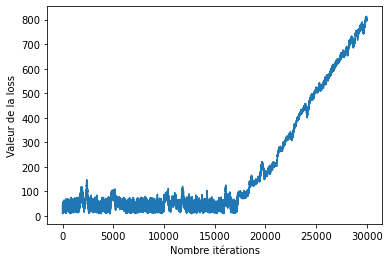

In [62]:
print_Loss(suivi_it_666, Loss_666)

In [63]:
print("w5 R2:", r2(w_5,100))
print("w6 R2:", r2(w_6,100))
print("w7 R2:", r2(w_7,100))
print("w8 R2:", r2(w_8,100))
print("w55 R2:", r2(w_55,100))
print("w66 R2:", r2(w_66,100))
print("w555 R2:", r2(w_555,100))
print("w666 R2:", r2(w_666,100))

# Nous avons qu'en utilisant w3, w4, w11 les modèles les plus précis

w5 R2: -0.14584900970900616
w6 R2: -0.1469738511318579
w7 R2: 0.13078443356359926
w8 R2: 0.35345063825129164
w55 R2: 0.4828854805565699
w66 R2: 0.5099604747819502
w555 R2: -8.014969814195588
w666 R2: -6467.360542831931


## Modèle sélectionné:


In [65]:
# Pour avoir un compromis entre précision et vitesse d'exécution
nb_ite_f, suivi_it_f, Loss_f, w_f = descent(W, X, Y, loss_2, 10e-5, 8000)
print("R2 du modèle sélectionné:", r2(w_f,100))

R2 du modèle sélectionné: 0.650604672508211


## Conclusion des différentes expérimentations

Nous avons travaillé avec 3 normes: L1, L2, L0/1.
La convergence de la descente de gradient dépend du pas que nous avons choisi. En effet, ce dernier impacte non seulement la convergence mais aussi la rapidité de convergence en fonction de s'il est trop petit ou grand.

Nous allons surtout pouvoir analyser le comportement de L1, L2 faute d'avoir un algorithme de descente de gradient se contentant d'avoir comme critère de sortie de boucle un nombre max d'itérations.
Dans quelques cas, avec un bon pas, nous avons convergence de la loss vers une valeur minimale ce qui fait que selon le pas alpha, la loss employée, le maximum d'itérations à faire peut être réduit augmentant ainsi les performances de notre modèle tout en gardant une bonne précision. Voici pour les deux loss, le meilleur paramétrage testé.

Pour la loss 2: (meilleur modèle R2 = 0.6556073044248025) Alpha = 10e-5, max itérations = 30000
Remarque, on peut descendre le maximum d'itération entre 8000 et 10000 sans que cela ne change profondément la précision de notre modèle.

Pour la loss 1: (meilleur modèle R2 = 0.6556073044248025) Alpha = 10e-5, max itérations = 30000
Remarque, on peut descendre le maximum d'itération vers 15000.

En utilisant la loss 2 on converge plus rapidement qu'avec la loss 1. Nous sélectionnons donc un modèle avec la loss 2 (voir ci-dessus)

Le modèle final n'est pas optimal pour un perceptron. Par exemple, pour la descente du gradient, la condition de sortie est uniquement basée sur le nombre d'itérations max. Ce critère tout seul est insuffisant pour optimiser l'algorithme de descente de gradient. On peut par exemple rajouter comme critère d'arrêt la convergence du vecteur poids vers un degré de précision en travaillant avec la norme des variations de ce vecteur à chaque itération.
Nous pouvons également modifier la fonction d'activation du perceptron en chosissant certaines avec de très bonnes propriétés comme la fonction logisitique, la fonction tanh...




# Going further

The following are extensions of the work previously done. If attempting them **do not modify** the code you produced above so that it can be evaluated.

### Improvements to gradient descent

Consider improving the gradient descent with:

 - Stochastic Gradient Descent (SGD), which means selecting a subset of the examples for training
 - Detection of convergence to halt the algorithm before the maximum number of iterations


### Data normalization

Different input features can have different units, and very different ranges.
Within the perceptron computation, these values will be summed together.
While gradient descent is normally able to deal with this (by adapting the weights of the perceptron for each input feature), standardizing the input features usually eases the perceptron training, and can sometimes improve accuracy.




```python
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True) 
X_normalized = sc.fit_transform(X)
```

Try applying a standard normalization to the input features (make sure that you keep a feature column that is always equal to 1). Is the convergence faster ? Try to quantify this speed-up. What about accuracy ?

In [66]:
from datetime import datetime

def sgd_descent(w_init, X, Y, loss, alpha, tolerance, max_iter):
    
    init_time = datetime.now()
    
    w = np.copy(w_init)
    w_prec = np.zeros(N)
    iterateur = []
    i = 0
    iterateur.append(i)
    
    Loss = []
    Loss.append(emp_loss(w, X, Y,loss))
    
    nb_sub = len(Y)
    
    emp_prec = 3000
    # On pourrait rajouter un critère de convergence lorsque le vecteur poids ne change quasi plus ou la norme
    #  OU emp_loss(w, X, Y)>= degrés de précision
    while abs(emp_loss(w, X, Y,loss)-emp_prec)>= tolerance and i < max_iter:
        w_prec = np.copy(w)
        emp_prec = emp_loss(w, X, Y,loss)
        k = 0
        for k in range(nb_sub):
            rand_int = np.random.randint(nb_sub/4,nb_sub)
            Xk = X[rand_int,:].reshape(1,X.shape[1])
            Yk = Y[rand_int].reshape(1,1)
            w=compute_update(w, Xk, Yk, loss,alpha)
        Loss.append(emp_loss(w, X, Y,loss))
        #print("i:", i)
        #print("loss:", emp_loss(w, X, Y,loss))
        #print("critere:", abs(emp_loss(w, X, Y,loss)-emp_prec))
        i=i+1
        iterateur.append(i)
        
        fin_time = datetime.now()
        
        #print("Temps exécution:", fin_time-init_time)
        
    #On retourne le nombre d'itérations nécéssaires, un tableau contenant les différents passages dans la boucles
    # en vue d'un affichage, la valeur de la Loss ainsi que le vecteur poids
    return i, iterateur, Loss, w

In [77]:
W_sgd = np.ones(N)
nb_ite_k, suivi_it_k, Loss_k, w_k = sgd_descent(W, X, Y, loss_2, 10e-5, 1e-6, 10000)
print("R2:",r2(w_k,100))
print("Nombre itérations",nb_ite_k)

R2: 0.6551813487916927
Nombre itérations 10000


Remarque : avec notre descente stochastique du gradient, nous obtenons un meilleur R2 qu'avec notre première version.

In [78]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True) 
X_normalized = sc.fit_transform(X)
X_normalized[:5,:1] = 1 # On remet la colonne que de 1 que nous n'avions plus
print(X_normalized[:5])

[[ 1.         -1.73302265  1.5423783  -0.03418367  0.55395671 -0.2294799
   0.62017367]
 [ 1.         -1.73302265  0.03714219 -0.07376475  0.09717082 -0.2294799
  -1.36438208]
 [ 1.          0.05415696  0.03714219 -0.03418367  2.58208609 -1.80462994
  -1.36438208]
 [ 1.         -1.73302265  1.5423783  -0.03418367  0.55395671 -0.2294799
   0.3721042 ]
 [ 1.          1.57656921 -1.46809393 -0.03418367 -0.34134364 -0.2294799
  -1.11631261]]


In [73]:
nb_ite_k_norm, suivi_it_k_norm, Loss_k_norm, w_k_norm = sgd_descent(W, X_normalized, Y, loss_2, 10e-5, 1e-6, 10000)

In [74]:
#Précision du modèle
print(r2(w_k_norm,100))

-0.5915331847745469


L'algorithme converge très très rapidement (20 premières secondes), en revanche il n'est pas du tout précis comme l'indique le R2 très loin de 1